Ensure the data downloaded from marine microplastics [dataset](https://experience.arcgis.com/experience/b296879cc1984fda833a8acc93e31476) is exported in csv format. The x, y data is garbage, probably for the visualisation website usage, but it's not to my knowledge any existing EPSG crs. I am assuming the latitude longitude is in the standard EPSG:4326 no reason for it do be anything else.

In [1]:
import geopandas as gpd
from geopandas.tools import sjoin

from shapely.geometry import Point, box

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

import datetime
import math

In [2]:
df = gpd.read_file(r"data_files/DataRecords.csv")
df

,FID,Date,Latitude,Longitude,Oceans,Regions,SubRegions,Microplastics Measurement (density),Unit,Density Class Range,...,Short Reference,Long Reference,DOI,Organization,Keywords,NCEI Accession Number,NCEI Accession Link,x,y,geometry
0,1,11/1/1992,18.83,-59.35,Atlantic Ocean,,,0.004320,pieces/m3,0.0005-0.005,...,Law et al.2010,"Law, K.L., S. Morét-Ferguson, N.A. Maximenko, ...",https://doi.org/10.1126/science.1192321,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,-6606811.7786,2134931.357500002,None
1,2,11/1/1992,18.83,-59.35,Atlantic Ocean,,,0.034556,pieces/m3,0.005-1,...,Law et al.2010,"Law, K.L., S. Morét-Ferguson, N.A. Maximenko, ...",https://doi.org/10.1126/science.1192321,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,-6606811.7786,2134931.357500002,None
2,3,11/2/1992,17.80,-59.43,Atlantic Ocean,,,0.008640,pieces/m3,0.005-1,...,Law et al.2010,"Law, K.L., S. Morét-Ferguson, N.A. Maximenko, ...",https://doi.org/10.1126/science.1192321,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,-6615717.3378,2014152.1148000024,None
3,4,11/2/1992,17.80,-59.43,Atlantic Ocean,,,0.000000,pieces/m3,0-0.0005,...,Law et al.2010,"Law, K.L., S. Morét-Ferguson, N.A. Maximenko, ...",https://doi.org/10.1126/science.1192321,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,-6615717.3378,2014152.1148000024,None
4,5,11/2/1992,17.03,-59.57,Atlantic Ocean,,,0.000000,pieces/m3,0-0.0005,...,Law et al.2010,"Law, K.L., S. Morét-Ferguson, N.A. Maximenko, ...",https://doi.org/10.1126/science.1192321,Sea Education Association,SEA,211007,https://www.ncei.noaa.gov/access/metadata/land...,-6631302.066599999,1924317.4963000007,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10715,10716,6/4/2015,42.02,3.24,Atlantic Ocean,Mediterranean Sea,Western Basin,0.036000,pieces/m3,0.005-1,...,de Haan et al.2019,"De Haan, W.P., A. Sanchez-Vidal, M. Canals. 20...",https://doi.org/10.1016/j.marpolbul.2019.01.053,University of Barcelona,RV Angeles Alvariño/RV IV Lluerna,253140,https://www.ncei.noaa.gov/access/metadata/land...,360304.1223000027,5163975.818000004,None
10716,10717,6/5/2015,42.37,3.29,Atlantic Ocean,Mediterranean Sea,Western Basin,1.004000,pieces/m3,1-10,...,de Haan et al.2019,"De Haan, W.P., A. Sanchez-Vidal, M. Canals. 20...",https://doi.org/10.1016/j.marpolbul.2019.01.053,University of Barcelona,RV Angeles Alvariño/RV IV Lluerna,253140,https://www.ncei.noaa.gov/access/metadata/land...,366612.15260000154,5216063.614200003,None
10717,10718,6/5/2015,41.75,3.06,Atlantic Ocean,Mediterranean Sea,Balearic Sea,0.335000,pieces/m3,0.005-1,...,de Haan et al.2019,"De Haan, W.P., A. Sanchez-Vidal, M. Canals. 20...",https://doi.org/10.1016/j.marpolbul.2019.01.053,University of Barcelona,RV Angeles Alvariño/RV IV Lluerna,253140,https://www.ncei.noaa.gov/access/metadata/land...,341008.66970000044,5124101.240699999,None
10718,10719,6/5/2015,41.62,2.78,Atlantic Ocean,Mediterranean Sea,Balearic Sea,1.986000,pieces/m3,1-10,...,de Haan et al.2019,"De Haan, W.P., A. Sanchez-Vidal, M. Canals. 20...",https://doi.org/10.1016/j.marpolbul.2019.01.053,University of Barcelona,RV Angeles Alvariño/RV IV Lluerna,253140,https://www.ncei.noaa.gov/access/metadata/land...,309468.1843999997,5103729.858800001,None


Drop useless columns. Use geom to store Point objects for latitude longitude.

In [3]:
df['Longitude'] = df['Longitude'].astype('float')
df['Latitude'] = df['Latitude'].astype('float')

In [4]:
df['geometry'] = df.apply(lambda x: Point(x['Longitude'], x['Latitude']), axis=1)
df = df[['FID', 'Date', 'geometry', 'Microplastics Measurement (density)', 'Oceans']]
df = df.rename(columns={'Microplastics Measurement (density)':'Density'})
df['Density'] = df['Density'].astype('float')
df.crs = "EPSG:4326"
df

/home/aloysius/.local/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:121: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,FID,Date,geometry,Density,Oceans
0,1,11/1/1992,POINT (-59.35000 18.83000),0.004320,Atlantic Ocean
1,2,11/1/1992,POINT (-59.35000 18.83000),0.034556,Atlantic Ocean
2,3,11/2/1992,POINT (-59.43000 17.80000),0.008640,Atlantic Ocean
3,4,11/2/1992,POINT (-59.43000 17.80000),0.000000,Atlantic Ocean
4,5,11/2/1992,POINT (-59.57000 17.03000),0.000000,Atlantic Ocean
...,...,...,...,...,...
10715,10716,6/4/2015,POINT (3.24000 42.02000),0.036000,Atlantic Ocean
10716,10717,6/5/2015,POINT (3.29000 42.37000),1.004000,Atlantic Ocean
10717,10718,6/5/2015,POINT (3.06000 41.75000),0.335000,Atlantic Ocean
10718,10719,6/5/2015,POINT (2.78000 41.62000),1.986000,Atlantic Ocean


The legend is disgusting but it gets the point across. We use only a certain box region of pacific ocean datapoints and reproject the crs to epsg:3832 which is localised for the pacific ocean in meters, which is more intuitive than looking at degrees. The closer the colours are together, the closer in date the samples were taken.

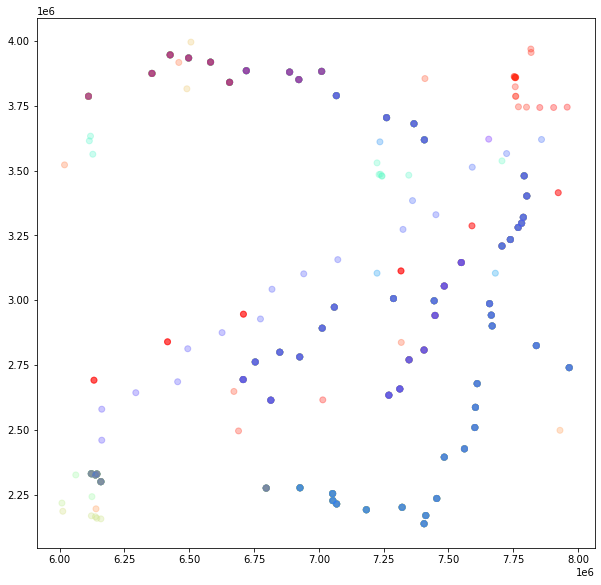

In [5]:
x = df[df['Oceans']=='Pacific Ocean'].to_crs(epsg=3832)
region = gpd.GeoDataFrame(gpd.GeoSeries([box(6e6, 2e6, 8e6, 4e6)]), columns=['geometry'], crs='EPSG:3832')
x = sjoin(x, region, how='inner')

fig, ax = plt.subplots(figsize=(10, 10))
x.plot(ax=ax, alpha=0.3, cmap='rainbow', column='Date')
plt.show()

https://stackoverflow.com/questions/15965166/what-are-the-lengths-of-location-coordinates-latitude-and-longitude

The scale above is 1e6, which means each unit is about 1000km. Looking at the map we can arbitrarily decide the region of area wherein points can be considered to be of the same region across different dates, 0.01e6 looks about right, which is about 10km. The problem is we cannot directly calculate using degrees as the distance between longitude units converge as we go closer to the poles (lines of the meridian converge at that point), we instead use haversine distance. We can look for clusters of points within a certain distance of each other, and for that we'll use DBSCAN with epsilon 1e4 (as the units are in meters) divided by 6371e3 to convert it into radians (only applicable for haversine of course, trying to convert from meters to radians is nonsensical).

In [6]:
coords = np.stack((df.geometry.x.values, df.geometry.y.values), axis=1)
coords = np.radians(coords)

db = DBSCAN(min_samples=2, eps=5e4/6371e3, metric='haversine', algorithm='ball_tree').fit(coords)
# num unique clusters
print(f"Number of unique clusters: {len(set(db.labels_))}")
print(f"{silhouette_score(coords, db.labels_, metric='haversine')}")

Number of unique clusters: 417
-0.23847098409655776


In [7]:
df['Cluster'] = db.labels_
df

,FID,Date,geometry,Density,Oceans,Cluster
0,1,11/1/1992,POINT (-59.35000 18.83000),0.004320,Atlantic Ocean,0
1,2,11/1/1992,POINT (-59.35000 18.83000),0.034556,Atlantic Ocean,0
2,3,11/2/1992,POINT (-59.43000 17.80000),0.008640,Atlantic Ocean,0
3,4,11/2/1992,POINT (-59.43000 17.80000),0.000000,Atlantic Ocean,0
4,5,11/2/1992,POINT (-59.57000 17.03000),0.000000,Atlantic Ocean,0
...,...,...,...,...,...,...
10715,10716,6/4/2015,POINT (3.24000 42.02000),0.036000,Atlantic Ocean,415
10716,10717,6/5/2015,POINT (3.29000 42.37000),1.004000,Atlantic Ocean,415
10717,10718,6/5/2015,POINT (3.06000 41.75000),0.335000,Atlantic Ocean,415
10718,10719,6/5/2015,POINT (2.78000 41.62000),1.986000,Atlantic Ocean,415


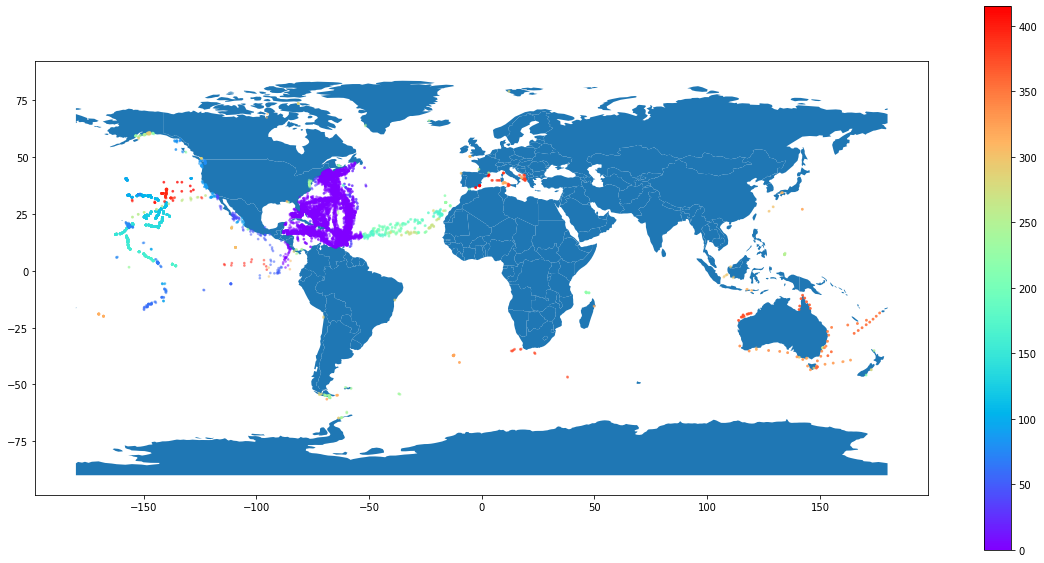

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(20,10))
world.to_crs(epsg=4326).plot(ax=ax)
df[df['Cluster'] != -1].plot(ax=ax, markersize=3, alpha=0.4, cmap='rainbow', column='Cluster', legend=True)
plt.show()

We groupby the points together in clusters and then .mean() to get rid of values that appear on the same date, ensuring that there are no duplicate values in the region. This means that certain clusters may now have only a single element, and we must remove those.

In [9]:
col_map = {col: "first" for col in df.columns}
col_map['Density'] = 'mean'
col_map.pop('Cluster')
col_map.pop('Date')

cluster_df = df.groupby(['Cluster', 'Date'], as_index=False).agg(col_map)
cluster_df 

,Cluster,Date,FID,geometry,Density,Oceans
0,-1,1/10/2016,9787,POINT (107.47000 0.93000),0.003000,Pacific Ocean
1,-1,1/10/2017,10013,POINT (49.28000 -12.27000),0.000000,Indian Ocean
2,-1,1/10/2018,10088,POINT (161.41000 -4.57000),23.000000,Pacific Ocean
3,-1,1/11/2015,8850,POINT (-2.00000 57.69000),0.000000,Atlantic Ocean
4,-1,1/11/2017,10341,POINT (95.76000 -54.84000),0.000000,Indian Ocean
...,...,...,...,...,...,...
6006,413,3/17/2015,10700,POINT (-0.86000 37.56000),0.350167,Atlantic Ocean
6007,413,3/18/2015,10706,POINT (-0.88000 37.51000),0.198000,Atlantic Ocean
6008,414,3/24/2015,10712,POINT (-2.70000 36.66000),0.313000,Atlantic Ocean
6009,415,6/4/2015,10715,POINT (3.24000 42.18000),0.311500,Atlantic Ocean


Find number of unique FIDs in a cluster, if there is only 1, remove that from existence.

In [10]:
idx = cluster_df.groupby('Cluster')['FID'].nunique() == 1
cluster_df.loc[cluster_df['Cluster'].isin(idx[idx].index.values), 'Cluster'] = -1
cluster_df = cluster_df.sort_values(['Cluster', 'Date']).set_index(['Cluster', 'Date'])
cluster_df

FID                     geometry    Density  \
Cluster Date                                                       
-1      1/10/2016   9787    POINT (107.47000 0.93000)   0.003000   
        1/10/2017  10013   POINT (49.28000 -12.27000)   0.000000   
        1/10/2018  10088   POINT (161.41000 -4.57000)  23.000000   
        1/11/2015   8850    POINT (-2.00000 57.69000)   0.000000   
        1/11/2017  10341   POINT (95.76000 -54.84000)   0.000000   
...                  ...                          ...        ...   
 412    4/25/1972  10663  POINT (-127.90000 35.62000)   0.003000   
 413    3/17/2015  10700    POINT (-0.86000 37.56000)   0.350167   
        3/18/2015  10706    POINT (-0.88000 37.51000)   0.198000   
 415    6/4/2015   10715     POINT (3.24000 42.18000)   0.311500   
        6/5/2015   10717     POINT (3.29000 42.37000)   1.108333   

                           Oceans  
Cluster Date                       
-1      1/10/2016   Pacific Ocean  
        1/10/2017    Indian Ocean  
        1/10/2018   Pacific Ocean  
        1/11/2015  Atlantic Ocean  
        1/11/2017    Indian Ocean  
...                           ...  
 412    4/25/1972   Pacific Ocean  
 413    3/17/2015  Atlantic Ocean  
        3/18/2015  Atlantic Ocean  
 415    6/4/2015   Atlantic Ocean  
        6/5/2015   Atlantic Ocean  

[6011 rows x 4 columns]

In [11]:
# num of actual clusters (including the -1 cluster)
len(cluster_df.index.unique(level='Cluster'))

307

Now we might have clusters that span long time frames. Some datapoints could be from 1972 and some could be from 2015. We must split readings that are too far apart in date into their own clusters.

Now we have a dataframe of the clusters, with individual points sorted by date. Plotting the number of FIDs per region, we see that we have a few outliers (excluding -1). We have to remove those outliers.

<AxesSubplot:xlabel='Cluster'>

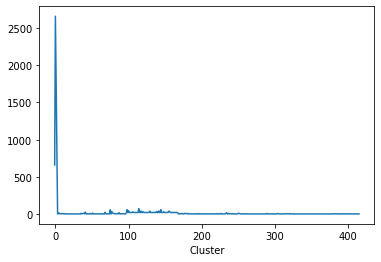

In [12]:
count_df = cluster_df.groupby('Cluster')['FID'].count()
count_df.plot()

In [13]:
idx = count_df < count_df.quantile(0.85)
cluster_df = cluster_df.loc[idx[idx].index.values]
cluster_df

FID                     geometry   Density  \
Cluster Date                                                       
3       3/2/1992     4274   POINT (-78.15000 12.17000)  0.000000   
        3/2/1993       72   POINT (-78.37000 12.48000)  0.000000   
4       10/25/1994    326   POINT (-62.35000 27.58000)  0.029158   
        10/25/2000   2568   POINT (-62.64000 27.74000)  0.043196   
        10/26/2000   2569   POINT (-62.71000 27.52000)  0.016661   
...                   ...                          ...       ...   
412     4/25/1972   10663  POINT (-127.90000 35.62000)  0.003000   
413     3/17/2015   10700    POINT (-0.86000 37.56000)  0.350167   
        3/18/2015   10706    POINT (-0.88000 37.51000)  0.198000   
415     6/4/2015    10715     POINT (3.24000 42.18000)  0.311500   
        6/5/2015    10717     POINT (3.29000 42.37000)  1.108333   

                            Oceans  
Cluster Date                        
3       3/2/1992    Atlantic Ocean  
        3/2/1993    Atlantic Ocean  
4       10/25/1994  Atlantic Ocean  
        10/25/2000  Atlantic Ocean  
        10/26/2000  Atlantic Ocean  
...                            ...  
412     4/25/1972    Pacific Ocean  
413     3/17/2015   Atlantic Ocean  
        3/18/2015   Atlantic Ocean  
415     6/4/2015    Atlantic Ocean  
        6/5/2015    Atlantic Ocean  

[774 rows x 4 columns]

In [14]:
cluster_df = cluster_df.reset_index("Date")
cluster_df.Date = pd.to_datetime(cluster_df.Date)

In [15]:
def datetimeCluster(cluster):
    DAYS = 60*60*24
    clustering = DBSCAN(eps=4*DAYS, min_samples=2).fit(np.array(cluster.Date.view(int)/ 10**9).reshape(-1, 1))
    
    return clustering.labels_

In [16]:
subclusters = []
for cluster_no, cluster in cluster_df.groupby(level=0):
    subclusters.extend(datetimeCluster(cluster))
cluster_df["SubCluster"] = subclusters

In [48]:
cluster_df.reset_index().set_index(["Cluster"])

,Date,FID,geometry,Density,Oceans,SubCluster
Cluster,,,,,,
3,1992-03-02,4274,POINT (-78.15000 12.17000),0.000000,Atlantic Ocean,-1
3,1993-03-02,72,POINT (-78.37000 12.48000),0.000000,Atlantic Ocean,-1
4,1994-10-25,326,POINT (-62.35000 27.58000),0.029158,Atlantic Ocean,-1
4,2000-10-25,2568,POINT (-62.64000 27.74000),0.043196,Atlantic Ocean,0
4,2000-10-26,2569,POINT (-62.71000 27.52000),0.016661,Atlantic Ocean,0
...,...,...,...,...,...,...
412,1972-04-25,10663,POINT (-127.90000 35.62000),0.003000,Pacific Ocean,-1
413,2015-03-17,10700,POINT (-0.86000 37.56000),0.350167,Atlantic Ocean,0
413,2015-03-18,10706,POINT (-0.88000 37.51000),0.198000,Atlantic Ocean,0


In [49]:
valid_clusters = cluster_df[cluster_df.SubCluster!=-1]
centroids = []

for cluster_no, cluster in valid_clusters.groupby(level=0):
    for subcluster_no, subcluster in cluster.groupby("SubCluster"):
        centroids.extend([gpd.GeoDataFrame(cluster, crs='EPSG:3832').dissolve().centroid.iloc[0] for i in range(len(subcluster))])
valid_clusters["Centroid"] = centroids

valid_clusters.reset_index(inplace=True)
valid_clusters.set_index(valid_clusters.groupby(["Cluster","SubCluster"]).ngroup().values, inplace=True)
valid_clusters.index.name = "Cluster"
valid_clusters.drop(columns=["Cluster", "SubCluster"], inplace=True)

/home/aloysius/.local/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:121: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [50]:
valid_clusters[:50]

,Date,FID,geometry,Density,Oceans,Centroid
Cluster,,,,,,
0,2000-10-25,2568,POINT (-62.64000 27.74000),0.043196,Atlantic Ocean,POINT (-62.60666666666666 27.60666666666667)
0,2000-10-26,2569,POINT (-62.71000 27.52000),0.016661,Atlantic Ocean,POINT (-62.60666666666666 27.60666666666667)
0,2000-10-27,2572,POINT (-62.47000 27.56000),0.001440,Atlantic Ocean,POINT (-62.60666666666666 27.60666666666667)
1,1996-07-12,3129,POINT (-57.83000 46.82000),0.015120,Atlantic Ocean,POINT (-56.9775 46.67833333333333)
1,1996-07-13,3130,POINT (-56.25000 47.58000),0.000000,Atlantic Ocean,POINT (-56.9775 46.67833333333333)
2,1995-07-15,473,POINT (-57.73000 45.72000),0.086392,Atlantic Ocean,POINT (-56.9775 46.67833333333333)
2,1995-07-16,474,POINT (-56.82000 46.38000),0.010800,Atlantic Ocean,POINT (-56.9775 46.67833333333333)
1,1996-07-17,3131,POINT (-56.07000 47.10000),0.005400,Atlantic Ocean,POINT (-56.9775 46.67833333333333)
1,1996-07-18,3132,POINT (-57.78000 47.08000),0.017352,Atlantic Ocean,POINT (-56.9775 46.67833333333333)
